In [167]:
import sys
sys.path.append("/home/sanketh/vqr/")

from experiments.data.mvn import LinearMVNDataProvider

N = 100000
d = 1
k = 20
T = 100
data_provider = LinearMVNDataProvider(d=d, k=k, seed=42)
X, Y = data_provider.sample(n=N)

In [168]:
import random
import numpy as np
from matplotlib import pyplot as plt

from vqr import VectorQuantileRegressor
from vqr.solvers.dual.regularized_lse import RegularizedDualVQRSolver, MLPRegularizedDualVQRSolver

linear = False

if linear:
    vqr_solver = RegularizedDualVQRSolver(
    verbose=True,
    lr=0.5,
    epsilon=5e-3,
    num_epochs=20000,
    gpu=True,
    device_num=1,
    lr_max_steps=10,
    lr_factor=0.9,
    lr_patience=300,
    lr_threshold=0.5 * 0.01,
)
else:
    vqr_solver = MLPRegularizedDualVQRSolver(
    verbose=True,
    lr=1.9,
    epsilon=5e-3,
    num_epochs=40000,
    hidden_layers=(10, 5, 1),
    skip=False,
    gpu=True,
    device_num=1,
    lr_max_steps=10,
    lr_factor=0.9,
    lr_patience=300,
    lr_threshold=0.5 * 0.01,
)
vqr = VectorQuantileRegressor(n_levels=T, solver=vqr_solver)
vqr.fit(X, Y)


  0%|                                                                 | 0/40000 [00:00<?, ?epochs/s]

VectorQuantileRegressor(n_levels=100,
                        solver=MLPRegularizedDualVQRSolver(eps=5e-03))

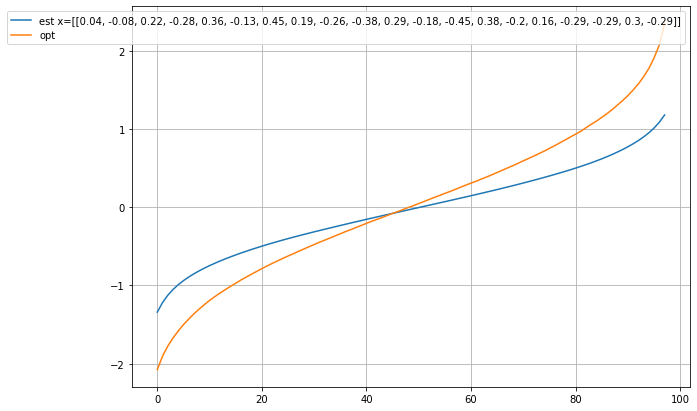

In [169]:
###
i = random.randrange(0, N)
x = X[[i]]
q = vqr.vector_quantiles(X=x)[0][0]

_, Y_ = data_provider.sample(n=N, x=x)

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(q[1:-1], label=f"est x={x.round(decimals=2).tolist()}")
ax.plot(np.quantile(Y, q=vqr.quantile_levels, method='lower')[1:-1], label="opt")
ax.legend()
ax.grid()
###

In [170]:
num_cond_samples = 10000
X_gt, Y_gt = data_provider.sample(n=num_cond_samples)
Y_est = np.stack([vqr.sample(n=1, x=X_gt[[i]]) for i in range(X_gt.shape[0])], axis=0)

In [171]:
# get gt conditional quantiles
gt_cond_quantiles = np.stack(
    [np.quantile(data_provider.sample(X_gt.shape[0], x=X_gt[[i]])[-1],
                 q=vqr.quantile_levels)[1:-1] for i in range(X_gt.shape[0])],
    axis=0
)
est_cond_quantiles = np.stack(
    [vqr.vector_quantiles(X=X_gt[i])[0][0][1:-1] for i in range(X_gt.shape[0])],
    axis=0
)

In [172]:
if k == 1:
    colors = ['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d']
    scatter_color = '#fff7bc'
    _, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].xaxis.set_tick_params(labelsize=20)
    axes[0].yaxis.set_tick_params(labelsize=20)
    axes[1].xaxis.set_tick_params(labelsize=20)
    axes[1].yaxis.set_tick_params(labelsize=20)
    axes[0].set_ylim([-3, 3])
    axes[1].set_ylim([-3, 3])
    axes[1].set_xlim([-0.5, 0.5])
    axes[0].set_xlim([-0.5, 0.5])
    axes[0].legend(fontsize=14)
    axes[1].legend(fontsize=14)
    axes[0].set_title("GT cond dist and quantiles", fontsize=20)
    axes[1].set_title("Est. cond dist and quantiles", fontsize=20)
    axes[0].scatter(X_gt, Y_gt, )
    axes[1].scatter(X_gt, Y_est,)
    i = 0
    for q in vqr.quantile_levels[1:-1:15]:
        i+=1
        axes[0].plot(X_gt, gt_cond_quantiles[:, int(q*100)], label=f"{q:.2f}", c=colors[i])
        axes[1].plot(X_gt, est_cond_quantiles[:, int(q*100)], label=f"{q:.2f}",c=colors[i], linewidth=6)

In [ ]:
error = (np.linalg.norm(gt_cond_quantiles - est_cond_quantiles, axis=0)) / np.linalg.norm(gt_cond_quantiles, axis=0)
plt.figure(figsize=(10, 10))
plt.plot(vqr.quantile_levels[1:-1], error*100)
plt.xlabel("Quantile level", fontsize=20)
plt.ylabel("Error (%)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Error in conditional quantiles averaged across X", fontsize=20)
plt.show()